<a href="https://colab.research.google.com/github/zhongzhihu/public/blob/main/Neural_Network_Trading_Hu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

author: Zhongzhi Hu

2 February 2024

**0. Introduction**

In this code, a neural network is trained to identify trading patterns in the S&P 500 Index. The model is trained using daily closing prices of the S&P 500 Index from 1990 to 2007. Subsequently, a trading simulation is conducted on an out-of-sample period spanning from 2008 to 2023. The simulation involves adjusting long and short allocations in the S&P 500 Index. These allocations are not leveraged and can range from -100% to 100% of the available balance, depending on the magnitude of the predicted next-day returns. Allocations are adjusted on a daily basis and occur at market close. Any remaining balance not allocated to the S&P 500 Index is accrued by the Risk-Free Rate (US 10-Year Treasury Note). The trading simulation takes into account trading costs at 0.02% of the trade size.

**1. Import libraries**

In [ ]:
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

# Import drive from Google Colab library to access uploaded data
from google.colab import drive
# Setting to allow Tensorflow to work on pc
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


**2. Import S&P Index data**



In [ ]:
#%% Import Stock Data downloaded from
# https://www.wsj.com/market-data/quotes/index/SPX/historical-prices

# Obtain access to data uploaded to Google drive
drive.mount('/content/drive')

# Import CSV file
df = pd.read_csv("/content/drive/MyDrive/trading_project/HistoricalPrices_WSJ.csv")

# Remove whitespaces from all column names
df.columns = [col.strip() for col in df.columns]

# Remove columns not used for our analysis
df.drop(['Open', 'High', 'Low'], inplace=True, axis=1)

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Rename column
df.rename(columns={"Close": "SP500Close"}, inplace=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**3. Create features from public market data**

In [ ]:
# Create daily returns in percentages
df['Return'] = df['SP500Close'].pct_change()

# Create feature: lagged returns
for i in range(1, 8):
    df[f'Return{i}DayAgo'] = df['Return'].shift(i)

# Create return next day (realized)
df['SP500ReturnNextDay'] = df['Return'].shift(-1)

# Erase Nan Data (it concerns oldest and newest observations)
df = df.dropna(subset=['SP500ReturnNextDay', 'Return7DayAgo'])
df = df.reset_index(drop=True)

# Create extra feature 'Consecutive_Days' which represents the consecutive
# days of losses or gains. E.g. a value of -3 denotes that the trading day
# is preceded by 3 days of consecutive losses. A value of positive 3 denotes
# that the trading day is preceded by 3 days of consecutive gains.

# Create a column 'Consecutive_Days' and initialize it with 0
df['Consecutive_Days'] = 0

# Identify days with consecutive wins (positive returns)
consecutive_wins = (df['Return'] > 0).astype(int).groupby(df['Return'].lt(0).cumsum()).cumsum()

# Identify days with consecutive losses (negative returns)
consecutive_losses = (df['Return'] < 0).astype(int).groupby(df['Return'].gt(0).cumsum()).cumsum()

# Update 'Consecutive_Days' based on consecutive wins and losses
df.loc[df['Return'] > 0, 'Consecutive_Days'] = consecutive_wins
df.loc[df['Return'] < 0, 'Consecutive_Days'] = -consecutive_losses

**4. Import US 10 Y Treasury Note data**

In [ ]:

#%% Import Risk Free Rate Data: US Treasury Rate 10Y downloaded from
# https://www.wsj.com/market-data/quotes/bond/BX/TMUBMUSD10Y/historical-prices

# Import CSV file
df_T = pd.read_csv("/content/drive/MyDrive/trading_project/HistoricalPrices_T10Y_WSJ.csv")

# Remove whitespaces from all column names
df_T.columns = [col.strip() for col in df_T.columns]

# Convert the 'Date' column to datetime format
df_T['Date'] = pd.to_datetime(df_T['Date'])

# Remove columns not used for our analysis
df_T.drop(['Open', 'High', 'Low'], inplace=True, axis=1)

# Rename column
df_T.rename(columns={"Close": "10YRiskFreeRate"}, inplace=True)

# Divide by 100 to denote percentages
df_T['10YRiskFreeRate'] = df_T['10YRiskFreeRate'] / 100

# Further divide by 365 since SP500 and Portfolio returns are on daily basis
df_T['10YRiskFreeRate'] = df_T['10YRiskFreeRate'] / 365

# Left join on earlier dataframe to add risk free rate
df = pd.merge(df, df_T, on='Date', how='left')

# Impute missing values (nan) by taking surrounding mean
df['10YRiskFreeRate'] = df['10YRiskFreeRate'].fillna(df['10YRiskFreeRate'].rolling(window=3,
                                                                                   min_periods=1,
                                                                                   center=True).mean())

**5. Plot S&P 500 index**

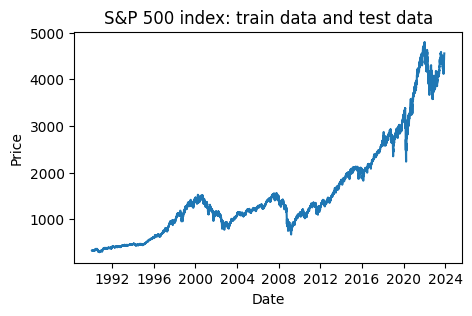

In [ ]:
# Split data into train and test data. Test data is chosen to include period of
# stable economic growth and financial crises (2008 GFC and COVID 19)
df_train = df[:4500]
df_test = df[4500:]

# Time series S&P index. Period: Train and Test Data
plt.figure(figsize=(5, 3))
plt.plot(df['Date'], df['SP500Close'])
plt.title('S&P 500 index: train data and test data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

**6. Plot distribution of the S&P returns conditional on the losses/gains of the preceding days**

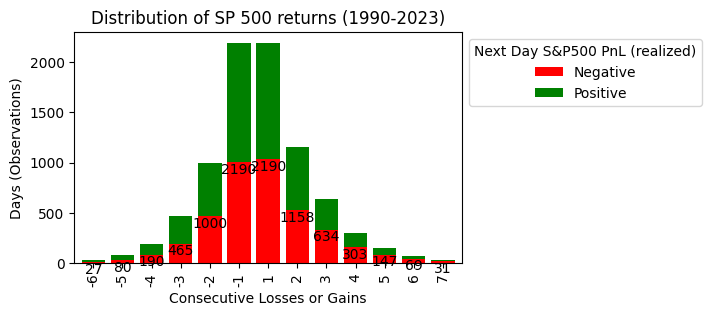

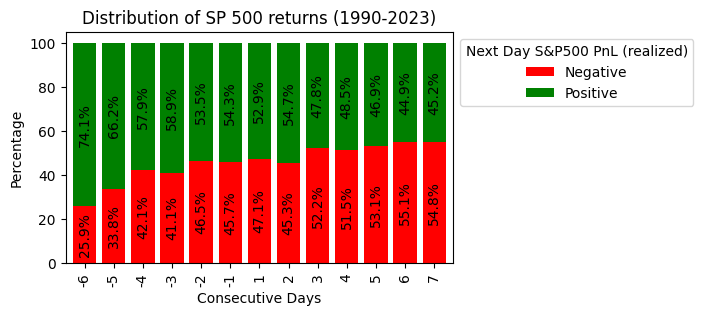

In [ ]:
def plot_count_and_percentage(data, min_observations=25, figsize=(5, 3)):

    # Create a new column 'Next_Day_Sign' to represent the sign of the return on the next day
    data['Next_Day_Sign'] = data['SP500ReturnNextDay'].apply(lambda x: 'Positive' if x > 0 else 'Negative')

    # Group by consecutive days and next day sign, then count occurrences
    grouped_data = data.groupby(['Consecutive_Days', 'Next_Day_Sign']).size().unstack().fillna(0)

    # Delete rows with less than min_observations observations
    grouped_data = grouped_data[(grouped_data['Negative'] + grouped_data['Positive']) >= min_observations]

    # Calculate percentages
    grouped_data_percentage = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100

    # Plotting Count
    fig, ax_count = plt.subplots(figsize=figsize)  # Adjusted figsize

    # Stack bar chart for consecutive gains and losses with counts
    grouped_data.plot(kind='bar', stacked=True, ax=ax_count,
                      color=['red', 'green'], width=0.8)

    # Customize the count plot
    ax_count.set_xlabel('Consecutive Losses or Gains')
    ax_count.set_ylabel('Days (Observations)')
    ax_count.set_title('Distribution of SP 500 returns (1990-2023)')
    ax_count.legend(title='Next Day S&P500 PnL (realized)', bbox_to_anchor=(1, 1))  # Move legend outside the plot

    # Add total count above each bar
    for p, total_count in zip(ax_count.patches, grouped_data.sum(axis=1)):
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        if total_count != 0:
            ax_count.text(x + width / 2,
                          y + height + 0.5,  # Adjusted to display above the entire stacked bar
                          int(total_count),  # Remove decimal
                          ha='center',
                          va='top',  # Adjusted to ensure the number is on top of the stacked bar
                          rotation=0)  # No rotation for total count

    # Show the count plot
    plt.show()

    # Print newline between the two plots
    print("\n")

    # Plotting Percentage
    fig, ax_percentage = plt.subplots(figsize=figsize)  # Adjusted figsize

    # Stack bar chart for consecutive gains and losses with percentages
    grouped_data_percentage.plot(kind='bar', stacked=True, ax=ax_percentage,
                                 color=['red', 'green'], width=0.8)

    # Customize the percentage plot
    ax_percentage.set_xlabel('Consecutive Days')
    ax_percentage.set_ylabel('Percentage')
    ax_percentage.set_title('Distribution of SP 500 returns (1990-2023)')
    ax_percentage.legend(title='Next Day S&P500 PnL (realized)',
                         bbox_to_anchor=(1, 1))  # Move legend outside the plot

    # Add labels to the bars with percentages
    for p in ax_percentage.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        percentage = '{:.1f}%'.format(height)
        if height != 0.0:
            ax_percentage.text(x + width / 2,
                               y + height / 2,
                               percentage,
                               ha='center',
                               va='center',
                               rotation=90,
                               rotation_mode='anchor')
    plt.show()

plot_count_and_percentage(df)

In the preceding plots, in the period 1990 to 2023, we observe that after experiencing several consecutive days of losses in the S&P500 Index, the likelihood of an actual gain in the index on the following day increases and is above 50%. Conversely, during winning streaks of the S&P500 Index lasting 3 days or more, the probability of a gain on the next day is observed to be smaller than 50%. Therefore, it is worth investigating to train a Neural Network to recognize trading patterns based on past consecutive loss and win streaks.


**7. Train Neural Network**

In [ ]:
#%% Neural Network model training

# Function for training Neural Network
def train_neural_network(df_train, features, hidden_layers, seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)

    # Select train and test data
    X_train = df_train[features]
    y_train = df_train['SP500ReturnNextDay']

    # Build the neural network model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(hidden_layers[0], activation='relu',
                                    input_shape=(X_train.shape[1],)))

    for neurons in hidden_layers[1:]:
        model.add(tf.keras.layers.Dense(neurons, activation='relu'))
    # Output layer (linear activation unit due to  positive and negative returns)
    model.add(tf.keras.layers.Dense(1, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Train the model on the train data
    model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=0)

    # Save the model
    model.save(f"/content/drive/MyDrive/trading_project/nn_trading_model_seed_{seed}.keras")

    return model


# Function for running single trading simulation
def run_trading_simulation(df, initial_cash, seed, trained_model, threshold, trans_cost=0.0002):
    """
    Runs trading simulation and plots the portfolio value over time

    Parameters:
    - data: Input DataFrame of test data.
    - initial_cash (float): starting value of the portfolio balance
    - threshold (int): denotes the min. threshold for predicted returns to be
      fully invested. If predicted returns>threshold, then the asset
      allocation to S&P500 will be 100%.
    - trans_cost: takes into account transaction cost and bid-ask spread as
      proportion of trade size

    Returns:
    - None
    """

    # Ensure index starts at 0
    df = df.reset_index(drop=True)

    # Initialize columns for daily P&L, bet size, and balance
    df['Daily_PnL'] = 0.0
    df['Bet_size'] = 0.0
    df['Balance_pre_PnL'] = initial_cash
    df['Balance_post_PnL'] = 0.0

    # Iterate over the DataFrame rows for trading simulation
    for index, row in df.iterrows():
        # For the first row, use initial_cash instead of Balance_pre_PnL
        if index == 0:
            bet_size = initial_cash * row['pred'] / threshold
        else:
            # Calculate the bet size based on the predicted return
            if abs(row['pred']) >= threshold:
                bet_size = df.at[index - 1, 'Balance_post_PnL'] * (1 if row['pred'] >= 0 else -1)
            else:
                bet_size = abs(row['pred']) / threshold * df.at[index - 1, 'Balance_post_PnL'] * (1 if row['pred'] >= 0 else -1)

        # Calculate the daily P&L and subtracting transaction cost
        daily_pnl = bet_size * row['SP500ReturnNextDay'] - abs(bet_size * trans_cost)

        # Update the balance columns
        balance_pre_pnl = initial_cash if index == 0 else df.at[index - 1, 'Balance_post_PnL']
        interest = (balance_pre_pnl - abs(bet_size)) * row['10YRiskFreeRate']
        balance_post_pnl = balance_pre_pnl + daily_pnl + interest

        # Update the DataFrame with daily P&L, bet size, and balance
        df.at[index, 'Bet_size'] = bet_size
        df.at[index, 'Daily_PnL'] = daily_pnl
        df.at[index, 'Interest'] = interest
        df.at[index, 'Balance_pre_PnL'] = balance_pre_pnl
        df.at[index, 'Balance_post_PnL'] = balance_post_pnl

    df['Percentage_Change'] = (df['Balance_post_PnL'] / df['Balance_post_PnL'].iloc[0] - 1) * 100  # Calculate wealth change

    return df

**8. Aggregate results for each model seed**

In [ ]:
# Function to aggregate results for each seed
def aggregate_results(all_results, starting_seed):
    # Initialize plots
    combined_plots = pd.DataFrame(all_results[0]['Date'])

    # Add each simulation's Balance_post_PnL to combined plots
    for i, result in enumerate(all_results):
        seed = starting_seed + i
        combined_plots[f'Simulation Seed {seed}'] = result['Balance_post_PnL']

    # Create DataFrame for aggregated statistics
    aggregated_stats = pd.DataFrame(all_results)

    return aggregated_stats, combined_plots

def plot_aggregated_results(combined_plots, df_test,
                            starting_seed, n_simulations):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot each simulation result with a unique label for the portfolio value
    for i in range(n_simulations):
        seed = starting_seed + i
        column_label = f'Simulation Seed {seed}'
        ax1.plot(combined_plots['Date'], combined_plots[column_label], label=column_label)

    # Plot S&P 500 index for comparison
    ax1.plot(df_test['Date'], df_test['SP500Close'], label='S&P 500 Index',
             color='black', linestyle='--')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Portfolio Value')
    ax1.set_title('Trading Simulations vs S&P 500 Index')

    # Secondary y-axis for the percentage change
    ax2 = ax1.twinx()
    starting_value = combined_plots[f'Simulation Seed {starting_seed}'].iloc[0]
    ax2.set_ylim(ax1.get_ylim()[0] / starting_value * 100, ax1.get_ylim()[1] / starting_value * 100)
    ax2.set_ylabel('Percentage Change (%)')
    ax1.legend(loc='upper left')

    plt.show()

**9. Run Trading Simulation on out-of-sample data (2008-2023)**

In [ ]:
#%% Trading simulation function
def run_simulations(starting_seed, n_simulations, df_train, df_test, df_T):
    aggregated_df = []
    balance_post_pnls = []
    result_dfs = {}
    features = ['Return', 'Return1DayAgo', 'Return2DayAgo', 'Return3DayAgo',
                'Return4DayAgo', 'Return5DayAgo', 'Consecutive_Days']

    for seed in range(starting_seed, starting_seed + n_simulations):
        np.random.seed(seed)
        tf.random.set_seed(seed)

        trained_model = train_neural_network(df_train,
                                             features, [32, 64, 32], seed)

        df_test_copy = df_test.copy()
        df_test_copy['pred'] = trained_model.predict(df_test_copy[features])

        # run trading simulation for different model with different seed
        result_df = run_trading_simulation(df_test_copy,
                                           df_test['SP500Close'].iloc[0],
                                           seed, trained_model, threshold=0.003)

        # Store the result DataFrame in the dictionary with the seed as the key
        result_dfs[f'result_df_{seed}'] = result_df

        stats = calculate_portfolio_stats(result_df, df_test, df_T)
        stats['portfolio_seed'] = seed  # Keep track of which seed was used
        aggregated_df.append(stats)

        balance_post_pnls.append(result_df['Balance_post_PnL'].tolist())

    aggregated_stats, combined_plots = aggregate_results(aggregated_df,
                                                         starting_seed)
    aggregated_stats = aggregated_stats.drop(columns=['Balance_post_PnL'])
    plot_aggregated_results(combined_plots, df_test,
                            starting_seed, n_simulations)

    balance_post_PnL_df = pd.DataFrame(balance_post_pnls).transpose()
    balance_post_PnL_df.columns = [f'Simulation {i+1}' for i in range(n_simulations)]

    return aggregated_stats, balance_post_PnL_df, result_dfs

**10. Calculate portfolio performance and risk metrics**

In [ ]:
def calculate_portfolio_stats(result_df, df_test, df_T):
    # Calculate CAGR
    t_end = result_df['Date'].iloc[-1]
    t_start = result_df['Date'].iloc[0]
    n_years = (t_end - t_start).days/365.25
    cagr = ((result_df['Balance_post_PnL'].iloc[-1]/result_df['Balance_pre_PnL'].iloc[0])**(1/n_years)-1)

    # Calculate average absolute invested in S&P 500 index
    avg_abs_invested = abs(result_df['Bet_size']/result_df['Balance_pre_PnL']).mean()

    # Calculate Sharpe Ratio
    result_df['Portfolio_Return'] = result_df['Balance_pre_PnL'].pct_change()
    temp_df = pd.merge(result_df[['Date', 'Portfolio_Return']],
                       df_T[['Date', '10YRiskFreeRate']], on='Date', how='left')
    temp_df['Excess_Return'] = temp_df['Portfolio_Return'] - temp_df['10YRiskFreeRate']
    mean_excess_return = temp_df['Excess_Return'].mean()
    std_excess_return = temp_df['Excess_Return'].std()
    sharpe_ratio = mean_excess_return / std_excess_return

    # Calculate beta
    merged_returns = pd.merge(result_df[['Date', 'Portfolio_Return']], df_test[['Date', 'Return']], on='Date')
    merged_returns = merged_returns.dropna()
    covariance_matrix = np.cov(merged_returns['Portfolio_Return'], merged_returns['Return'])
    covariance = covariance_matrix[0, 1]
    market_variance = np.var(merged_returns['Return'])
    beta = covariance / market_variance

    # Calculate Sortino Ratio
    downside_returns = temp_df[temp_df['Excess_Return'] < 0]['Excess_Return']
    downside_deviation = np.sqrt(np.mean(np.square(downside_returns)))
    sortino_ratio = mean_excess_return / downside_deviation

    # Calculate Maximum Drawdown
    result_df['running_max'] = result_df['Balance_pre_PnL'].cummax()
    result_df['drawdown'] = (result_df['Balance_pre_PnL'] - result_df['running_max']) / result_df['running_max']
    max_drawdown = result_df['drawdown'].min()

    return {
        'Date': result_df['Date'],
        'CAGR': cagr,
        'avg_abs_invested': avg_abs_invested,
        'Beta': beta,
        'sharpe_ratio': sharpe_ratio,
        'sortino_ratio': sortino_ratio,
        'max_drawdown': max_drawdown,
        'Balance_post_PnL': result_df['Balance_post_PnL'],
    }

def calculate_sp500_stats(df_test, df_T):
    # Calculate CAGR
    t_end = df_test['Date'].iloc[-1]
    t_start = df_test['Date'].iloc[0]
    n_years = (t_end - t_start).days / 365.25
    cagr = ((df_test['SP500Close'].iloc[-1] / df_test['SP500Close'].iloc[0]) ** (1 / n_years) - 1)

    # Calculate Sharpe Ratio
    temp_df = pd.merge(df_test[['Date', 'Return']],
                       df_test[['Date', '10YRiskFreeRate']], on='Date', how='left')
    temp_df['Excess_Return'] = temp_df['Return'] - temp_df['10YRiskFreeRate']
    mean_excess_return = temp_df['Excess_Return'].mean()
    std_excess_return = temp_df['Excess_Return'].std()
    sharpe_ratio = mean_excess_return / std_excess_return

    # Calculate Sortino Ratio
    downside_returns = temp_df[temp_df['Excess_Return'] < 0]['Excess_Return']
    downside_deviation = np.sqrt(np.mean(np.square(downside_returns)))
    sortino_ratio = mean_excess_return / downside_deviation

    # Calculate Maximum Drawdown
    df_test['running_max'] = df_test['SP500Close'].cummax()
    df_test['drawdown'] = (df_test['SP500Close'] - df_test['running_max']) / df_test['running_max']
    max_drawdown = df_test['drawdown'].min()

    return pd.DataFrame({
        'CAGR': [cagr],
        'avg_abs_invested':[1],
        'Beta': [1],
        'sharpe_ratio': [sharpe_ratio],
        'sortino_ratio': [sortino_ratio],
        'max_drawdown': [max_drawdown],
        'portfolio_seed': ['S&P500'],
    }, index=[0])

**11. Execution of code**

126/126 [==============================] - 0s 1ms/step


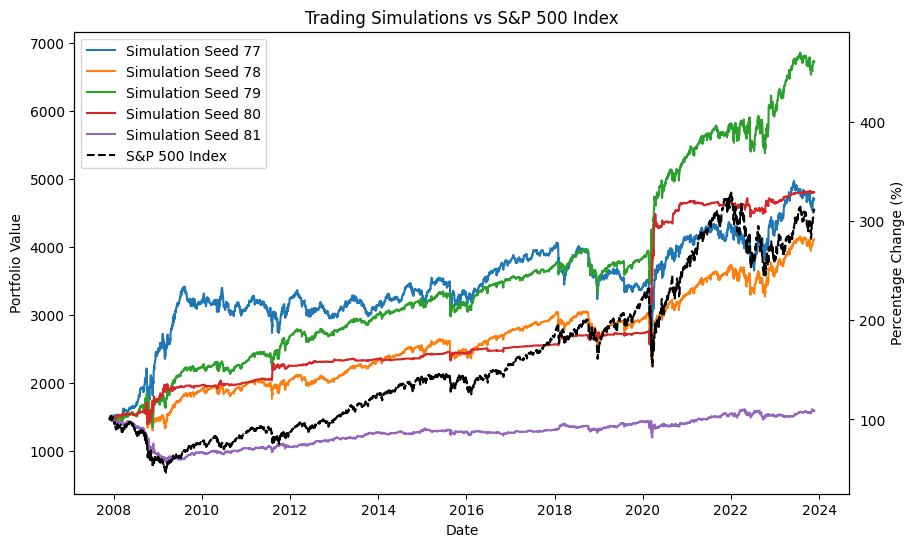

<ipython-input-10-5986e5c102af>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['running_max'] = df_test['SP500Close'].cummax()
<ipython-input-10-5986e5c102af>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['drawdown'] = (df_test['SP500Close'] - df_test['running_max']) / df_test['running_max']


In [ ]:
#%% Set starting seed and amount of simulations
starting_seed = 77
n_simulations = 5

# Execute code
portfolio_stats, balance_post_PnL, result_dfs = run_simulations(starting_seed, n_simulations,
                                                                df_train, df_test, df_T)

# Obtain statistics
portfolio_stats.drop(['Date'], axis=1, inplace=True)
index_stats = calculate_sp500_stats(df_test, df_T)
combined_stats = pd.concat([portfolio_stats, index_stats], axis=0)
combined_stats.set_index('portfolio_seed', inplace=True)

**12. Show performance and risk metrics**

In [ ]:
print(tabulate(combined_stats, headers='keys', tablefmt='fancy_grid'))

╒══════════════════╤════════════╤════════════════════╤══════════╤════════════════╤═════════════════╤════════════════╕
│ portfolio_seed   │       CAGR │   avg_abs_invested │     Beta │   sharpe_ratio │   sortino_ratio │   max_drawdown │
╞══════════════════╪════════════╪════════════════════╪══════════╪════════════════╪═════════════════╪════════════════╡
│ 77               │ 0.0755314  │           0.6571   │ 0.478117 │     0.0277364  │      0.0289393  │      -0.33441  │
├──────────────────┼────────────┼────────────────────┼──────────┼────────────────┼─────────────────┼────────────────┤
│ 78               │ 0.0664423  │           0.439742 │ 0.587025 │     0.026129   │      0.0262744  │      -0.263756 │
├──────────────────┼────────────┼────────────────────┼──────────┼────────────────┼─────────────────┼────────────────┤
│ 79               │ 0.0998273  │           0.440791 │ 0.507231 │     0.0399041  │      0.0423583  │      -0.267993 │
├──────────────────┼────────────┼────────────────────┼──